# importing necessary libararies

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import cross_val_score
import joblib

# reading dataset

In [2]:
dataset = pd.read_csv('../Datasets/regression.csv')
dataset.head()

,property_id,location_id,page_url,property_type,price,location,city,province_name,latitude,longitude,baths,area,purpose,bedrooms,date_added,agency,agent,Area Type,Area Size,Area Category
0,237062,3325,https://www.zameen.com/Property/g_10_g_10_2_gr...,Flat,10000000,G-10,Islamabad,Islamabad Capital,33.679890,73.012640,2,4 Marla,For Sale,2,02-04-2019,NaN,NaN,Marla,4.0,0-5 Marla
1,346905,3236,https://www.zameen.com/Property/e_11_2_service...,Flat,6900000,E-11,Islamabad,Islamabad Capital,33.700993,72.971492,3,5.6 Marla,For Sale,3,05-04-2019,NaN,NaN,Marla,5.6,5-10 Marla
2,386513,764,https://www.zameen.com/Property/islamabad_g_15...,House,16500000,G-15,Islamabad,Islamabad Capital,33.631486,72.926559,6,8 Marla,For Sale,5,07-17-2019,NaN,NaN,Marla,8.0,5-10 Marla
3,656161,340,https://www.zameen.com/Property/islamabad_bani...,House,43500000,Bani Gala,Islamabad,Islamabad Capital,33.707573,73.151199,4,2 Kanal,For Sale,4,04-05-2019,NaN,NaN,Kanal,2.0,1-5 Kanal
4,841645,3226,https://www.zameen.com/Property/dha_valley_dha...,House,7000000,DHA Defence,Islamabad,Islamabad Capital,33.492591,73.301339,3,8 Marla,For Sale,3,07-10-2019,Easy Property,Muhammad Junaid Ceo Muhammad Shahid Director,Marla,8.0,5-10 Marla


# Data Preprocessing

In [3]:

def preprocess_dataset(dataset):
    ## Droping id's and unique data of examples before dropping duplicates
    drop_columns = ['property_id', 'location_id', 'page_url']
    df = dataset.drop(columns=drop_columns, axis=1)
    df = df.drop_duplicates()
    
    ## Droping N/A values
    df = df.dropna()
    
    ## Changing marla and kanal to meter to keep consistent in data representing
    marla_mask = df['Area Type'] == "Marla"
    df.loc[marla_mask, 'Area Size'] *= 25.2929
    df.loc[~marla_mask, 'Area Size'] *= 505.857
    df = df.drop(columns=['Area Type'], axis=1)
    
    ## Define numeric columns
    numeric_columns = ['price', 'baths', 'Area Size', 'bedrooms']
    
    # Removing outliers
    new_df = df.copy()
    for col in numeric_columns:
        Q1 = new_df[col].quantile(0.25)
        Q3 = new_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        new_df[col] = np.where(
            new_df[col] > upper_bound,
            upper_bound,
            np.where(
                new_df[col] < lower_bound,
                lower_bound,
                new_df[col]
            )
        )
    df = new_df
    
    # Droping unneeded features
    drop_columns = ['date_added', 'Area Category', 'area']
    df = df.drop(columns=drop_columns, axis=1)
    
    # Clustering locations
    kmeans = KMeans(n_clusters=3, random_state=42, n_init=10).fit(df[['latitude', 'longitude']])
    df['location_cluster'] = kmeans.labels_
    
    # Scaling numeric data
    scaler = StandardScaler()
    df[['price', 'baths', 'bedrooms', 'Area Size', 'latitude', 'longitude', 'location_cluster']] = \
        scaler.fit_transform(df[['price', 'baths', 'bedrooms', 'Area Size', 'latitude', 'longitude', 'location_cluster']])
    
    # Encoding categorical variables
    categorical_columns = ['property_type', 'city', 'province_name', 'purpose', 'location', 'agent', 'agency']
    encoder = ce.TargetEncoder(cols=categorical_columns)
    df = encoder.fit_transform(df, df['price'])
    
    return df


In [4]:
df = preprocess_dataset(dataset)
df

,property_type,price,location,city,province_name,latitude,longitude,baths,purpose,bedrooms,agency,agent,Area Size,location_cluster
4,0.299512,-0.488322,0.650838,-0.277787,-0.277787,0.948778,0.642994,0.055600,0.356178,-0.115082,0.051162,0.015431,-0.328073,0.064868
7,-0.383268,-0.442191,-0.480151,-0.277787,-0.277787,1.003104,0.541430,-0.372944,0.356178,-0.636644,-0.240975,-0.070751,-0.583895,0.064868
8,0.299512,1.991237,0.650838,-0.277787,-0.277787,0.961538,0.577140,1.769776,0.356178,1.971166,0.051162,0.015431,1.377403,0.064868
9,-0.052760,1.414595,-0.208267,-0.277787,-0.277787,0.998077,0.542887,0.912688,0.356178,0.928042,0.116677,0.135433,1.377403,0.064868
10,-0.383268,1.126275,-0.249398,-0.277787,-0.277787,1.011196,0.584794,0.055600,0.356178,-0.115082,-0.070043,0.270352,-0.455984,0.064868
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
168441,0.299512,0.636129,-0.383051,0.038174,0.038174,-1.286770,-1.331319,-1.230032,0.356178,1.449604,0.144200,0.077566,-0.100676,-1.175549
168442,0.299512,-0.171169,-0.383051,0.038174,0.038174,-1.289929,-1.331575,-1.230032,0.356178,-0.115082,0.144200,0.077566,-0.328073,-1.175549
168443,0.299512,0.664961,-0.383051,0.038174,0.038174,-1.290607,-1.338001,-1.230032,0.356178,1.449604,0.144200,0.077566,-0.100676,-1.175549
168444,0.299512,-0.257666,-0.383051,0.038174,0.038174,-1.291167,-1.336564,-1.230032,0.356178,-0.115082,0.144200,0.077566,-0.356498,-1.175549


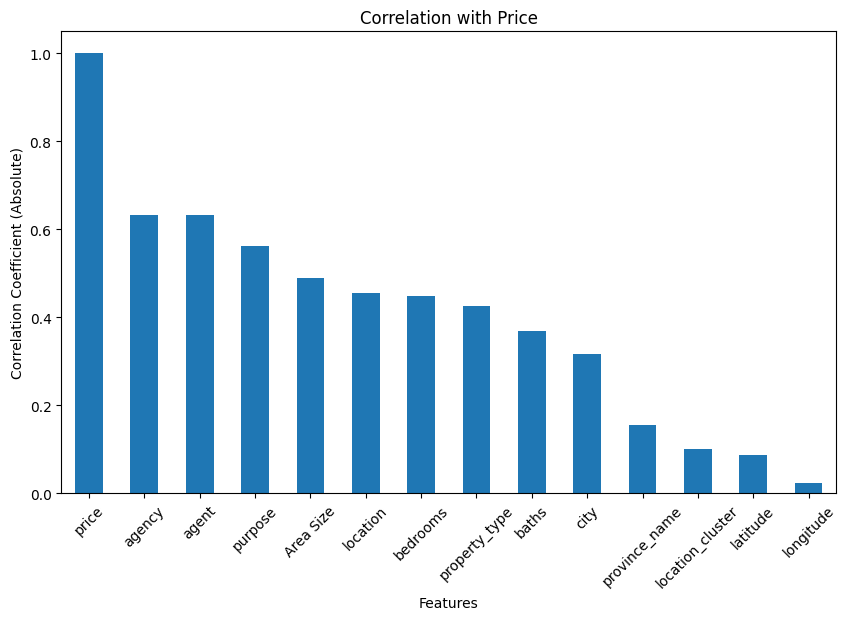

In [5]:
# Compute Pearson correlation coefficients
correlation_with_price = df.corr()['price'].abs().sort_values(ascending=False)

# Plotting the correlation coefficients
plt.figure(figsize=(10, 6))
correlation_with_price.plot(kind='bar')
plt.title('Correlation with Price')
plt.xlabel('Features')
plt.ylabel('Correlation Coefficient (Absolute)')
plt.xticks(rotation=45)
plt.show()

# splitting data

In [6]:
X = df.drop(columns=['price'], axis=1)
y = df[['price']]

X.shape, y.shape

((111272, 13), (111272, 1))

In [7]:

X_train , X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, y_train.shape

((89017, 13), (89017, 1))

# Model Traning

In [8]:

# y_train = y_train.values.ravel()

# svr = SVR(kernel='rbf')
# svr.fit(X_train, y_train)

# joblib.dump(svr, 'models/svrmodel.pkl')



In [9]:
svr_model = joblib.load('models/svrmodel.pkl')

y_pred = svr_model.predict(X_test)

# Model Evalution

In [10]:
r2 = r2_score(y_test, y_pred)
test_mse_scaled = mean_squared_error(y_test, y_pred)
print(f"R-squared: {r2}\nmean_square_error_test: {test_mse_scaled}")

R-squared: 0.9247415623875347
mean_square_error_test: 0.07466250332180482


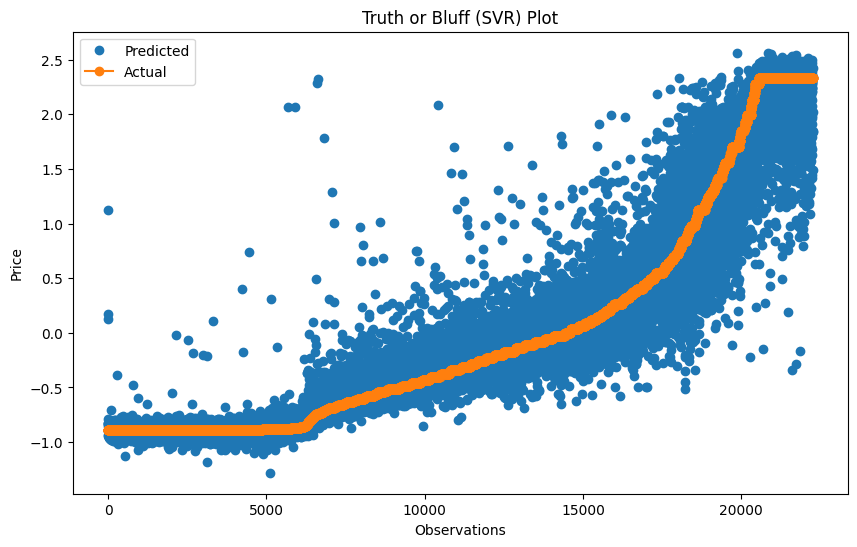

In [11]:
import numpy as np
import matplotlib.pyplot as plt

# Sort the predictions and actual values based on the actual values
sorted_indices = np.argsort(y_test.values.flatten())
y_test_sorted = y_test.values.flatten()[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]

# Plotting the actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_pred_sorted, 'o', label='Predicted')
plt.plot(y_test_sorted, 'o-', label='Actual')
plt.title('Truth or Bluff (SVR) Plot')
plt.xlabel('Observations')
plt.ylabel('Price')
plt.legend()
plt.show()


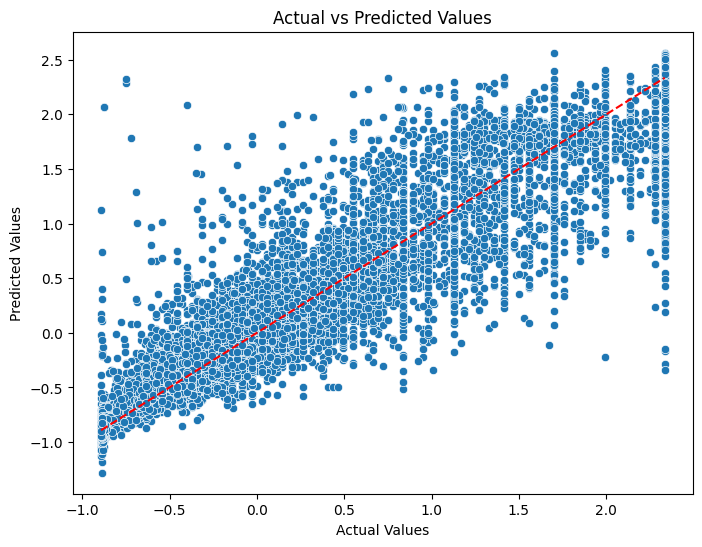

In [12]:
y_true = np.ravel(y_test)
y_pred = np.ravel(y_pred)

# Plot actual vs predicted values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_true, y=y_pred)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], color='red', linestyle='--') # Diagonal line representing perfect prediction
plt.show()

# hesitation is defeat